**Компромисс дисперсии и смещения**

В этом notebook я надеюсь подробно разобрать вопрос компромиса между смещением (bias) и дисперсией (variance) в машинном обучении.

Вдохновлено соотсветсвующим разделом в <a href="https://www.statlearning.com/">ISLR</a>.

In [1]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

import scipy.interpolate as inter

n = 1000

# Введение

Утверждается что средне квадратическую ошибку модели (Mean Square Error, MSE) можно разложить на три составляющие:
- Дисперсию;
- Квардрат смещения;
- Неустранимую ошибку.

Или записывая серез формулу:

$$\mathbb{E}(y_0 - \hat{f}(x_0))^2 = Var(\hat{f}(x_0)) + [Bias(\hat{f}(x_0))]^2 + Var(\varepsilon). \tag{1}$$

Где:
- $\hat{f}(x)$ - некоторая модель описывающая данные;
- $x_0$ - некоторое произвольное контрольное значение предикторов;
- $y_0$ - некоторое произвольное контрольное значение оклика;
- $\varepsilon$ - неустранимая ошибка модели (irreducible error); в нее вкладывается та информация о описываемом процессе, которой нет в полученной выборке;
- $Var(\hat{f}(x_0))$ - дисперсия полученной модели; эта величина должна быть тем больше, чем сильнее предстказания модели будут меняться от измениния выбоки;
- $Bias(\hat{f}(x_0))$ - смещение модели эта величина тем меньше, чем точнее модель подогнанна к описываемому просцессу;
- $Var(\varepsilon)$ - дисперсия неустранимой ошибки; чем полнее и точнее наши данные, тем меньше эта величина;
- $\mathbb{E}(y_0 - \hat{f}(x_0))^2$ - математическое ожидание ошибки полученной модели.

В различных источниках к этой теме очень часто прикладывают график подобный этому:

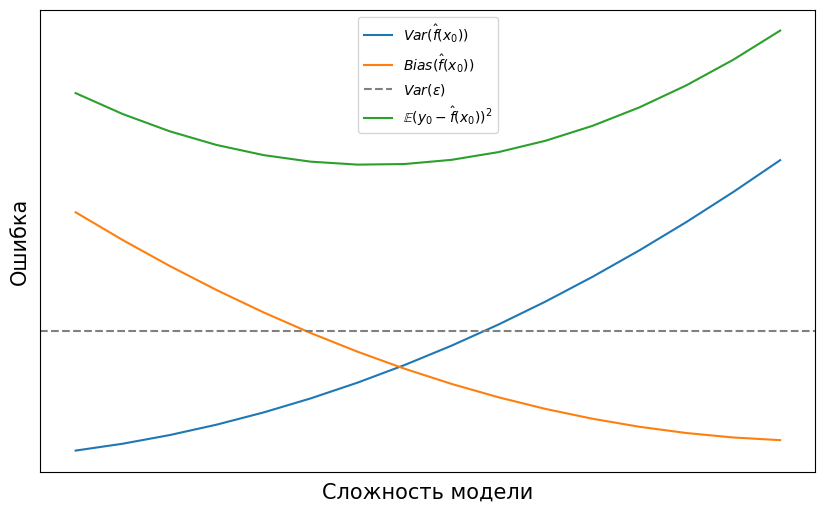

In [2]:
x_plot_range = np.arange(0,0.8, 0.05)
variance = 3*(x_plot_range)**2 + x_plot_range
bias = 3*(x_plot_range)**2 - 4.8*x_plot_range + 2
irrecible_error = 1
model_error = variance + bias + irrecible_error

plt.figure(figsize = [10, 6])
plt.plot(x_plot_range, variance)
plt.plot(x_plot_range, bias)
plt.axhline(irrecible_error, color = "gray", linestyle = "dashed")
plt.plot(x_plot_range, model_error)

plt.xticks([])
plt.yticks([])

plt.xlabel("Сложность модели", fontsize = 15)
plt.ylabel("Ошибка", fontsize = 15)

ans = plt.legend([
    "$Var(\hat{f}(x_0))$",
    "$Bias(\hat{f}(x_0))$",
    "$Var(\\varepsilon)$",
    "$\mathbb{E}(y_0 - \hat{f}(x_0))^2$"
])

Далее я на примере простой задачи регрессии попытаюсь провести такой вычислитеньный эксперимент, который приведет именно к такому графику.

# Идея эксперимента

Пусть имеется некоторе уравнение которое обисывает некоторых достаточно сложный полином. В следующей ячейке происходит его генерация.

In [3]:
x_p = np.array([0, 1, 2, 3, 4])
y_p = np.array([2, 4, 3, 5, 4])
poly = inter.lagrange(x_p, y_p)

Итак, полученный полином записывается в форме: 

<!-- l = []
for i, c, in enumerate(poly.coef):
    sign = ("+" if c >= 0 else "-")
    l += [sign + str(abs(round(c,4))) + ("x^{{{}}}".format(i) if i != 0 else "")]
"".join(l) -->

$$f(x)=-0.0002+0.0105x^{1}-0.2263x^{2}+2.7223x^{3}-20.1388x^{4}+94.3996x^{5}-278.1615x^{6}+491.6866x^{7}-466.4732x^{8}+178.181x^{9}+2.0x^{10}$$

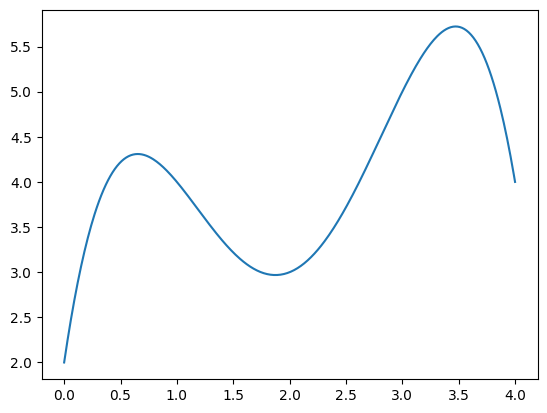

In [20]:
def f(x):
    X = np.concatenate(
        [(x**a)[:, np.newaxis] for a in range(len(poly.coef))],
        axis = 1
    )
    return np.dot(X, poly.coef[::-1][:, np.newaxis]).ravel()
    
x_range = np.arange(0, 4.01, 0.01)
ans = plt.plot(x_range, f(x_range))

Пусть зачение объясняемой переменной объясняется так:

$y = f(x) + \varepsilon$

Пусть для нашего примера $\varepsilon \sim N(0, 0.5)$. То есть, по определениею нормального распределения $Var(\varepsilon) = 0.5^2=0.25$. Таким образом мы можем сгенерировать множество выборок подобных $(x_i,y_i), i \in \overline{1,n}$. Некторые из них предствлены на рисунке:

In [54]:
y = lambda x: f(x) + np.random.normal(0, 0.5, x.shape)

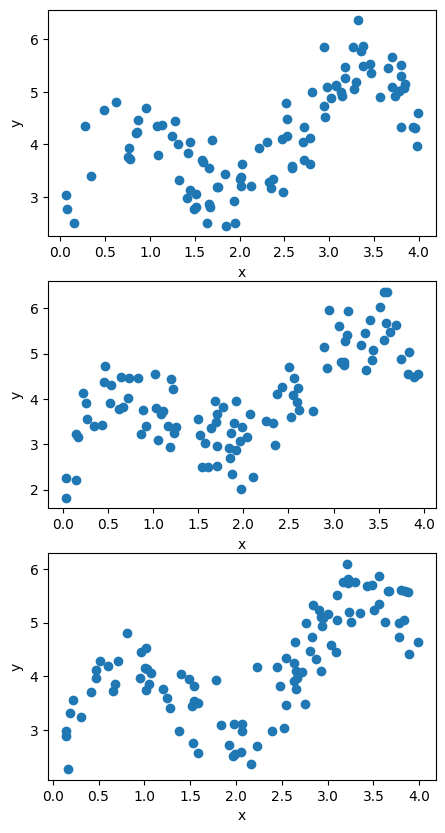

In [55]:
np.random.seed(20)
sample_size = 100
examples_count = 3

X_samples = np.random.uniform(0, 4, [sample_size, examples_count])
Y_samples = np.concatenate(
    [
        y(X_samples[:, col_i])[:, np.newaxis] for col_i in range(examples_count)
    ],
    axis = 1
)

plt.figure(figsize = [5, 10])
for i in range(examples_count):
    plt.subplot(examples_count, 1, i+1)
    plt.scatter(
        X_samples[:, i], Y_samples[:,i]
    )
    plt.xlabel("x");ans = plt.ylabel("y")

Обычно об $f(x)$ нам ничего, кроме выборки неизвестно. Потому задачу по формированию модели можно поставить следующим образом - найти такое $\hat{f}(x)$ что-бы оно максимально походило на дейсвительное $f(x)$ располагая только выборкой. Методы подгонки моделей решают задачу оптимальным (или близким к оптимальному) образом при условии, что исследователь определился с идентификационной формой модели. Таким образом, задача, обычно, сводится именно к определению идентификационной формы модели.

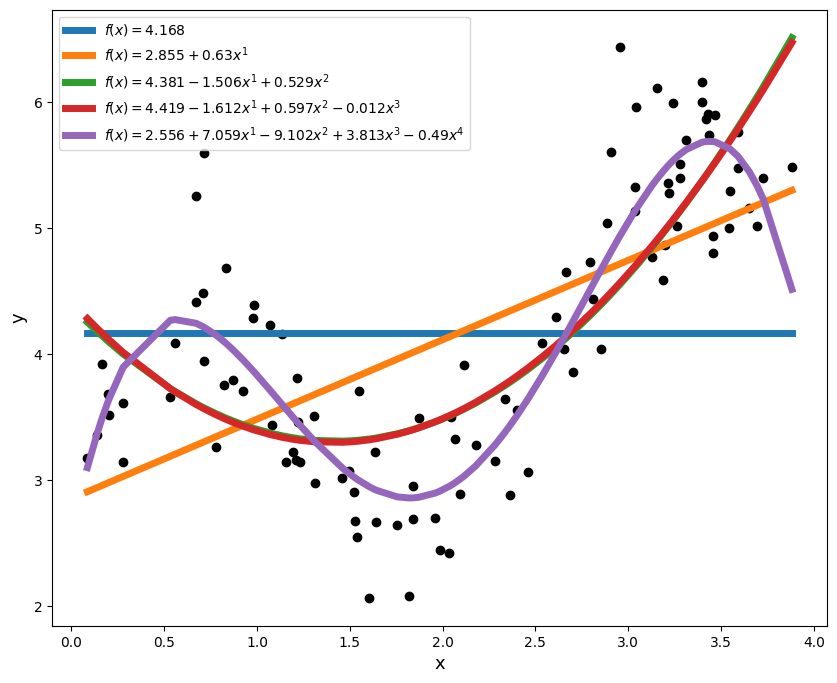

In [56]:
def get_poly_matrix(X, p = 2):
    return np.concatenate(
        [np.array(X)[:, np.newaxis]**(i) for i in range(p+1)],
        axis = 1
    )

def get_poly_model(X, y, p = 2):
    
    X_matr = get_poly_matrix(X, p)
    
    return LinearRegression(
        fit_intercept=False
    ).fit(X_matr, y)

def get_poly_predict(X, y, p = 2):
    
    X_matr = get_poly_matrix(X, p)
    return LinearRegression(
        fit_intercept=False
    ).fit(X_matr, y).predict(X_matr)

np.random.seed(21)
sample_size = 100
poly_max = 5

X_sample = np.sort(np.random.uniform(0, 4, sample_size))
Y_sample = y(X_sample)

plt.figure(figsize = [10, 8])

legend_line = ""
legend_list = []

for i in range(poly_max):
    
    X_matr = get_poly_matrix(X_sample, p = i)
    model = LinearRegression(
        fit_intercept=False
    ).fit(X_matr, Y_sample)
    pred = model.predict(X_matr)
    plt.plot(X_sample, pred, linewidth = 5)
    
    eq = "$f(x)="
    for i, c in enumerate(model.coef_.round(3)):
        if c != 0:
            eq += \
                ("+" if c > 0 and i != 0 else "") + \
                str(c) + \
                ("x^{{{}}}".format(i) if i != 0 else "")
    eq += "$"
    legend_list += [eq]

    
ans = plt.scatter(X_sample, Y_sample, color = "black")
plt.legend(legend_list)

plt.xlabel("x", fontsize = 13);ans = plt.ylabel("y", fontsize = 13)

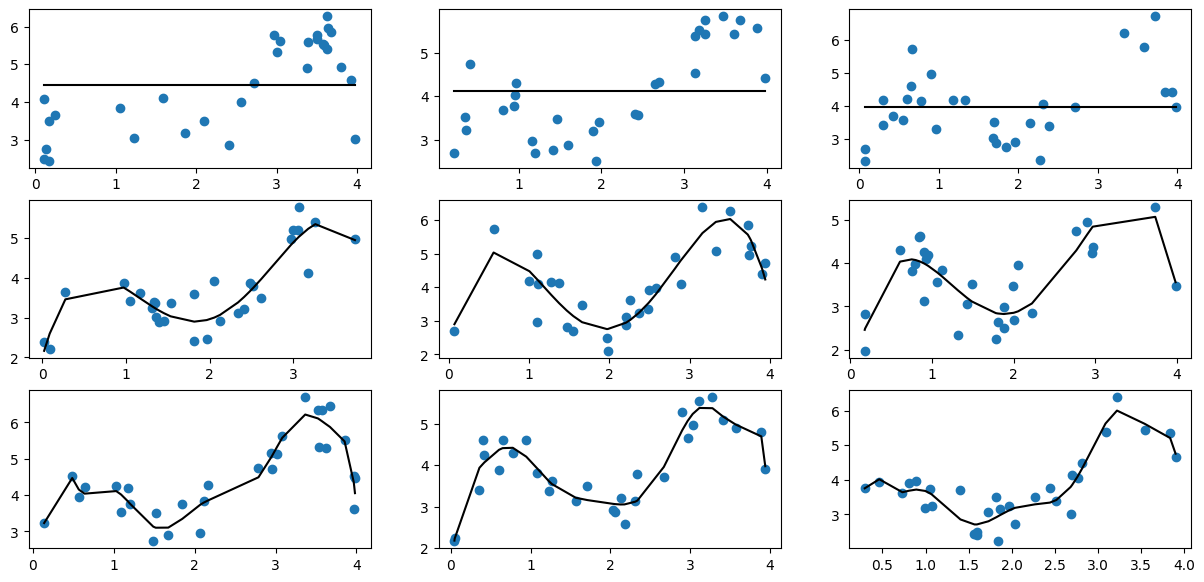

In [57]:
plt.figure(figsize = [15, 7])

sample_size = 30

for i in range(3):
    for j, p in enumerate([0,4, 10]):
        
        plt.subplot(3,3,i+1+3*j)
        X_sample = np.sort(np.random.uniform(0, 4, sample_size))
        Y_sample = y(X_sample)
        X_matrix = np.zeros([sample_size, poly_max])

        plt.scatter(X_sample, Y_sample)
        plt.plot(
            X_sample,
            get_poly_predict(X_sample, Y_sample, p),
            color = "black"
        )

In [50]:
np.random.seed(30)
exp_count = 2000
sample_size = 30
poly_max = 14

X_matrix = np.zeros([sample_size, poly_max])
# x_ij - результат i-го эксперимента для j-го полинома
prediction = np.zeros([exp_count, poly_max])
residual = np.zeros([exp_count, poly_max])

for i in range(exp_count):
    # генерирую выборку актуальную на этой итерации
    X_sample = np.random.uniform(0, 4, sample_size)
    Y_sample = y(X_sample)
    X_matrix = np.zeros([sample_size, poly_max])
    
    # индекс того наблюдения которое будет использоваться для проверки
    i_0 = 0
    
    # пробегаюсь по возможным коэффициентам полинома
    # подгонаяю соответсвующие модели
    for j in range(poly_max):
        pred = get_poly_predict(X_sample, Y_sample, j)
        prediction[i,j] = pred[i_0]
        residual[i,j] = (pred[i_0] - Y_sample[i_0])

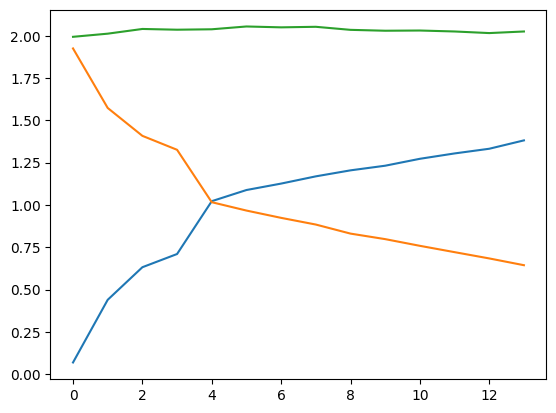

In [51]:
plt.plot(np.var(prediction, axis = 0))
plt.plot(np.mean(residual**2, axis = 0))
plt.plot(np.var(prediction, axis = 0) + np.mean(residual**2, axis = 0))

In [53]:
np.argsort(
    (np.var(prediction, axis = 0) + np.mean(residual**2, axis = 0))
)

array([ 0,  1, 12, 13, 11,  9, 10,  8,  3,  4,  2,  6,  7,  5])